In [11]:
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

In [10]:
# %pip install tensorflow

In [9]:
# %pip install scikit-learn

In [ ]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras import layers # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [13]:
import os
from PIL import Image

# Define paths
flip_dir = os.path.join('images', 'training', 'flip')
notflip_dir = os.path.join('images', 'training', 'notflip')

# Load images for 'flip'
flip_images = []
for filename in os.listdir(flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(flip_dir, filename)
        img = Image.open(img_path)
        flip_images.append(img)

# Load images for 'notflip'
notflip_images = []
for filename in os.listdir(notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(notflip_dir, filename)
        img = Image.open(img_path)
        notflip_images.append(img)

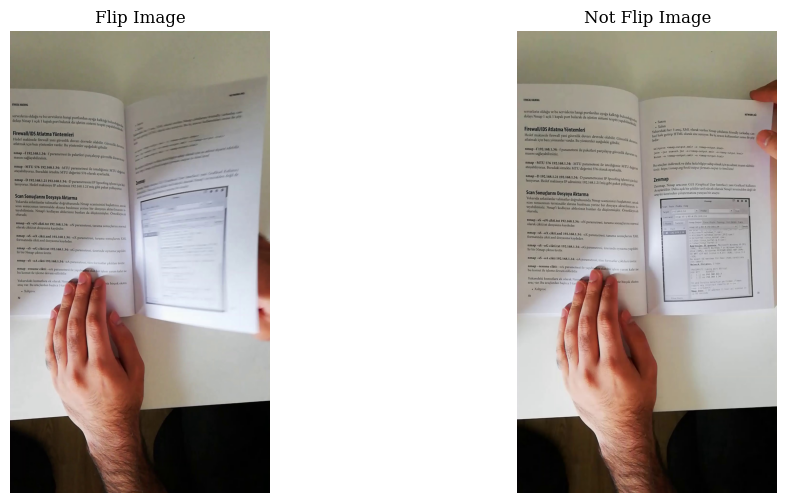

In [39]:
# Display one image from each category
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'serif'   

plt.subplot(1, 2, 1)
plt.imshow(flip_images[0])
plt.title('Flip Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(notflip_images[0])
plt.title('Not Flip Image')
plt.axis('off')

plt.show()

#### New Files

In [30]:
for filename in os.listdir(os.path.join('images_new','Flipping')):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        old_path = os.path.join('images_new','Flipping', filename)
        new_path = os.path.join('images_new','Flipping', filename.replace(' ', '_'))
        os.rename(old_path, new_path)

for filename in os.listdir(os.path.join('images_new','NotFlipping')):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        old_path = os.path.join('images_new','NotFlipping', filename)
        new_path = os.path.join('images_new','NotFlipping', filename.replace(' ', '_'))
        os.rename(old_path, new_path)

In [31]:
# Define paths
flip_dir = os.path.join('images_new', 'Flipping')
notflip_dir = os.path.join('images_new', 'NotFlipping')

# Load images for 'flip'
flip_images_new = []
for filename in os.listdir(flip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(flip_dir, filename)
        img = Image.open(img_path)
        flip_images_new.append(img)

# Load images for 'notflip'
notflip_images_new = []
for filename in os.listdir(notflip_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        img_path = os.path.join(notflip_dir, filename)
        img = Image.open(img_path)
        notflip_images_new.append(img)

In [36]:
len(flip_images_new), len(notflip_images_new)

(84, 92)

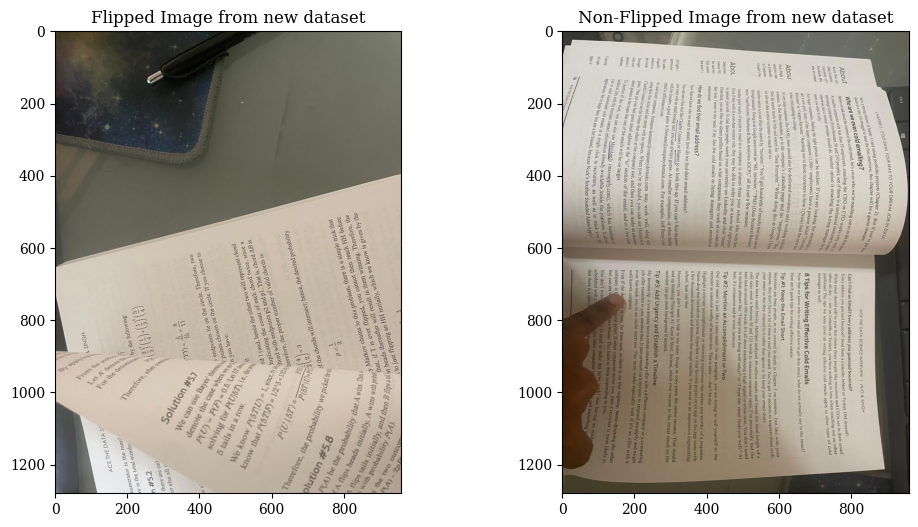

In [38]:
import seaborn as sns
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(flip_images_new[7])
plt.title('Flipped Image from new dataset')

plt.subplot(1, 2, 2)
plt.imshow(notflip_images_new[7])
plt.title('Non-Flipped Image from new dataset') 

plt.show()

In [40]:
from random import shuffle

# Create labeled datasets
flip_dataset = [(img, 1) for img in flip_images]
notflip_dataset = [(img, 0) for img in notflip_images]

# Create labeled datasets for new data
flip_dataset_new = [(img, 1) for img in flip_images_new]
notflip_dataset_new = [(img, 0) for img in notflip_images_new]

# Combine and shuffle
combined_dataset = flip_dataset + notflip_dataset
combined_dataset_new = flip_dataset_new + notflip_dataset_new
shuffle(combined_dataset)
shuffle(combined_dataset_new)

In [126]:
from PIL import Image
import pickle

# Resize all images in combined_dataset to 224x224 and save with labels
resized_combined_dataset = []
for img, label in combined_dataset:
    resized_img = img.resize((224, 224))
    resized_combined_dataset.append((resized_img, label))

with open('resized_combined_dataset.pkl', 'wb') as f:
    pickle.dump(resized_combined_dataset, f)

In [127]:
resized_combined_dataset_new = []
for img, label in combined_dataset_new:
    resized_img = img.resize((224, 224))
    resized_combined_dataset_new.append((resized_img, label))

with open('resized_combined_dataset_new.pkl', 'wb') as f:
    pickle.dump(resized_combined_dataset_new, f)

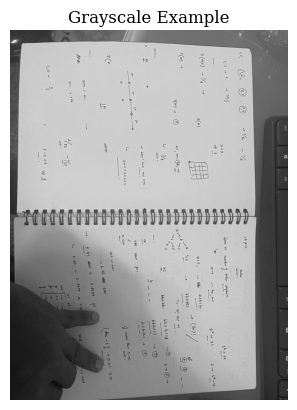

In [48]:
from PIL import ImageOps

# Convert the first 10 images in combined_dataset_new to grayscale
grayscale_dataset = []
for img, label in combined_dataset_new[:10]:
    gray_img = ImageOps.grayscale(img)
    grayscale_dataset.append((gray_img, label))

# Example: show the first grayscale image
plt.imshow(grayscale_dataset[0][0], cmap='gray')
plt.title('Grayscale Example')
plt.axis('off')
plt.show()

#### Training a generative adversarial network (GAN) on the new images for image augmentation

#### Flipped images generation using GAN

In [169]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

# Image preprocessing for GAN (resize and normalize)
gan_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class GANImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

gan_flip_dataset = GANImageDataset(flip_images_new, transform=gan_transform)
gan_flip_loader = DataLoader(gan_flip_dataset, batch_size=len(flip_images_new), shuffle=True)

In [170]:
# Generator: CNN-based (output shape: 3x224x224)
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),   # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),          # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),          # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),            # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),            # (3, 64, 64)
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [171]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),      # [B, 64, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),    # [B, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),   # [B, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),   # [B, 512, 4, 4]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 4, 0, bias=False),    # [B, 1, 1, 1]
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

In [184]:
# Instantiate models
latent_dim = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [185]:
for data in gan_flip_loader:
    print(data.shape)

torch.Size([84, 3, 64, 64])


In [186]:
# Training loop (short example)
epochs = 1000
for epoch in range(epochs):
    for data in gan_flip_loader:
        # Handle both cases: (img, label) or just img
        if isinstance(data, tuple):
            imgs = data[0]  # Take only images
        else:
            imgs = data

        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Train Discriminator
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)

        optimizer_D.zero_grad()

        # print(f"The shape of discriminator input: {imgs.shape}")
        # print(f"The shape of discriminator output: {discriminator(imgs).shape}")
        # print(f"The shape of generated images: {gen_imgs.shape}")
        # print(f"The shape of valid labels: {valid.shape}")

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
    
    if epoch % 25 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        


Epoch 1/1000 | D Loss: 0.8079 | G Loss: 1.2749
Epoch 26/1000 | D Loss: 0.1752 | G Loss: 5.7098
Epoch 51/1000 | D Loss: 0.4390 | G Loss: 3.4276
Epoch 76/1000 | D Loss: 0.4482 | G Loss: 2.4883
Epoch 101/1000 | D Loss: 0.3329 | G Loss: 3.2504
Epoch 126/1000 | D Loss: 0.3636 | G Loss: 2.1262
Epoch 151/1000 | D Loss: 0.2929 | G Loss: 2.4171
Epoch 176/1000 | D Loss: 0.3031 | G Loss: 1.9342
Epoch 201/1000 | D Loss: 0.2547 | G Loss: 2.9388
Epoch 226/1000 | D Loss: 0.2111 | G Loss: 3.0025
Epoch 251/1000 | D Loss: 0.2104 | G Loss: 3.1574
Epoch 276/1000 | D Loss: 0.1846 | G Loss: 2.9254
Epoch 301/1000 | D Loss: 0.2187 | G Loss: 2.5881
Epoch 326/1000 | D Loss: 0.1876 | G Loss: 3.4755
Epoch 351/1000 | D Loss: 0.1410 | G Loss: 2.2921
Epoch 376/1000 | D Loss: 0.0936 | G Loss: 3.3052
Epoch 401/1000 | D Loss: 0.1159 | G Loss: 3.5540
Epoch 426/1000 | D Loss: 0.0797 | G Loss: 3.2955
Epoch 451/1000 | D Loss: 0.0858 | G Loss: 3.3033
Epoch 476/1000 | D Loss: 0.0709 | G Loss: 3.1091
Epoch 501/1000 | D Loss: 

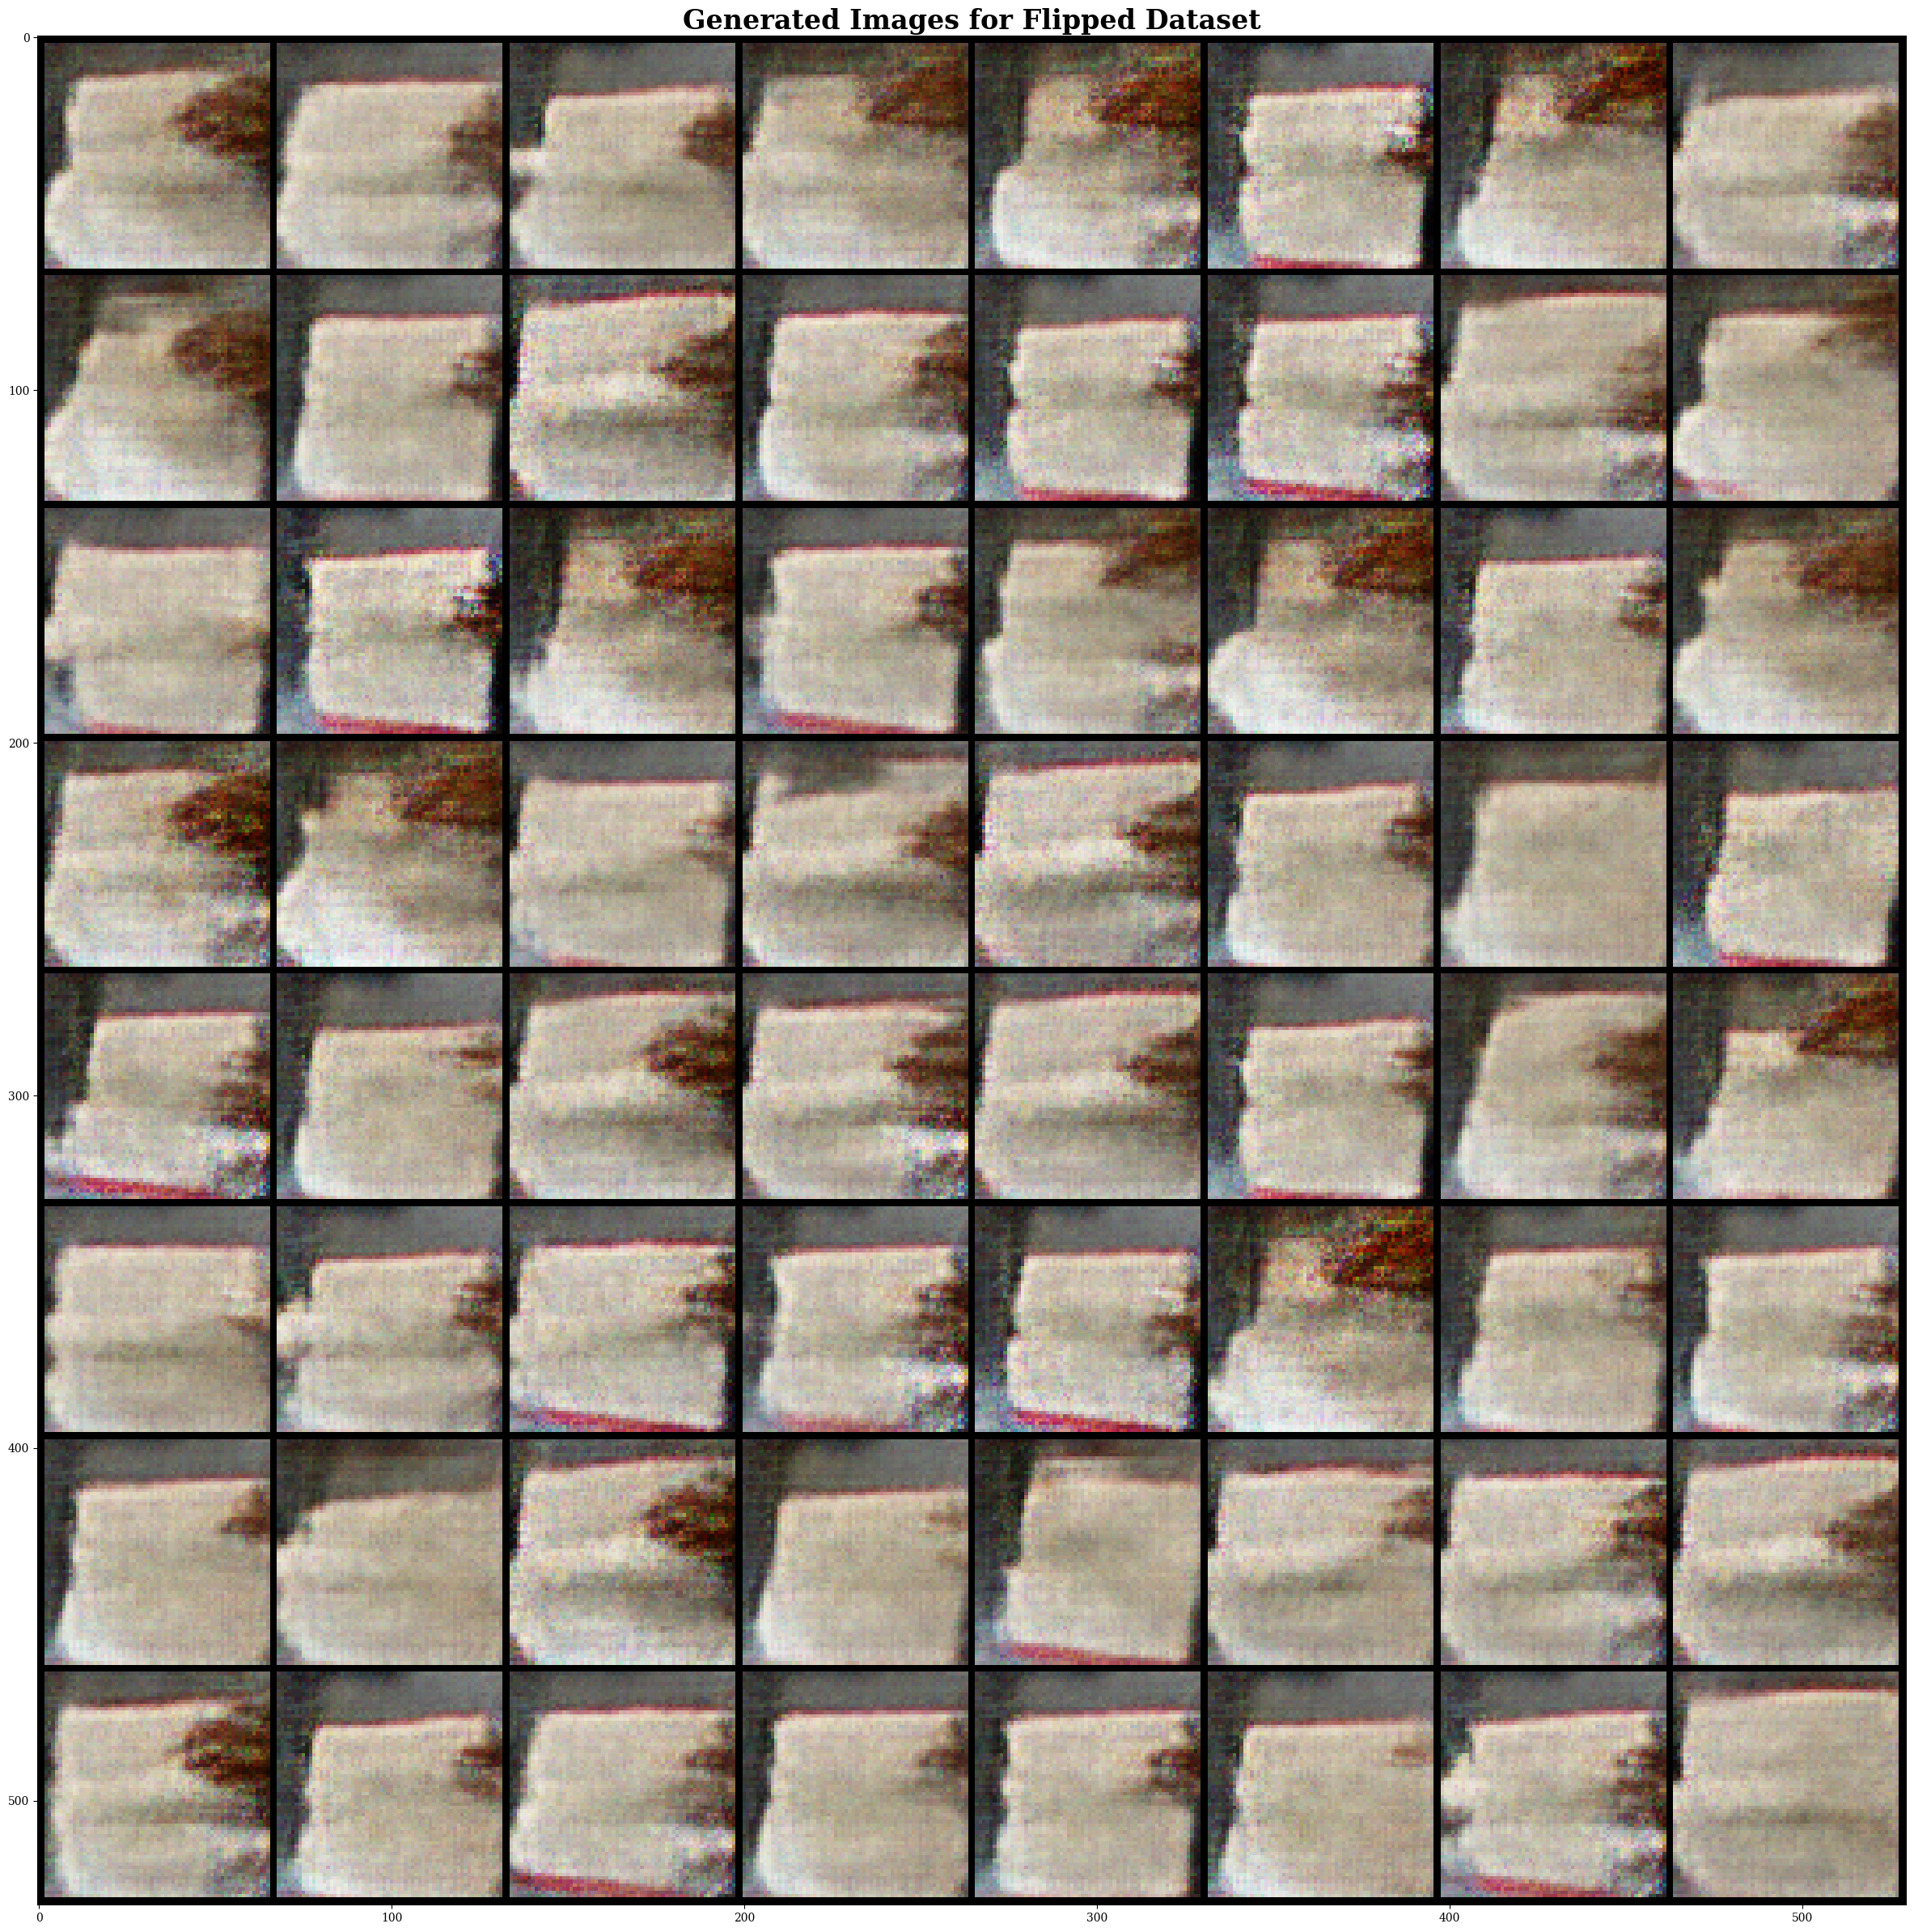

In [187]:
from torchvision.utils import make_grid
# Generate new examples
gen_imgs = generator(torch.randn(1500, latent_dim, 1, 1, device=device)).detach().cpu()

plt.figure(figsize=(150, 30))
plt.imshow(make_grid(gen_imgs[:64], nrow=8, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.title("Generated Images for Flipped Dataset", fontsize=24, fontweight='bold')
plt.show()

#### Generated images for non-flipped case

In [188]:
non_flip_dataset = GANImageDataset(notflip_images_new, transform=gan_transform)
non_flip_loader = DataLoader(non_flip_dataset, batch_size=len(notflip_images_new), shuffle=True)

In [189]:
# Training loop (short example)
epochs = 1000
for epoch in range(epochs):
    for data in non_flip_loader:
        # Handle both cases: (img, label) or just img
        if isinstance(data, tuple):
            imgs = data[0]  # Take only images
        else:
            imgs = data

        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Train Discriminator
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)

        optimizer_D.zero_grad()

        # print(f"The shape of discriminator input: {imgs.shape}")
        # print(f"The shape of discriminator output: {discriminator(imgs).shape}")
        # print(f"The shape of generated images: {gen_imgs.shape}")
        # print(f"The shape of valid labels: {valid.shape}")

        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
    
    if epoch % 25 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 1/1000 | D Loss: 5.9390 | G Loss: 4.1363
Epoch 26/1000 | D Loss: 0.4853 | G Loss: 3.5510
Epoch 51/1000 | D Loss: 0.5246 | G Loss: 4.7299
Epoch 76/1000 | D Loss: 0.3465 | G Loss: 4.4921
Epoch 101/1000 | D Loss: 0.5334 | G Loss: 5.9257
Epoch 126/1000 | D Loss: 0.2747 | G Loss: 4.7108
Epoch 151/1000 | D Loss: 0.2258 | G Loss: 2.6093
Epoch 176/1000 | D Loss: 0.2137 | G Loss: 2.7235
Epoch 201/1000 | D Loss: 0.1923 | G Loss: 3.1421
Epoch 226/1000 | D Loss: 0.1529 | G Loss: 3.0442
Epoch 251/1000 | D Loss: 0.1424 | G Loss: 3.0480
Epoch 276/1000 | D Loss: 0.1384 | G Loss: 3.5807
Epoch 301/1000 | D Loss: 0.2383 | G Loss: 3.1444
Epoch 326/1000 | D Loss: 0.1582 | G Loss: 4.5393
Epoch 351/1000 | D Loss: 0.1236 | G Loss: 2.9245
Epoch 376/1000 | D Loss: 0.0902 | G Loss: 3.1412
Epoch 401/1000 | D Loss: 0.0727 | G Loss: 3.2972
Epoch 426/1000 | D Loss: 0.1284 | G Loss: 3.1706
Epoch 451/1000 | D Loss: 0.0723 | G Loss: 3.5159
Epoch 476/1000 | D Loss: 0.0632 | G Loss: 3.6114
Epoch 501/1000 | D Loss: 

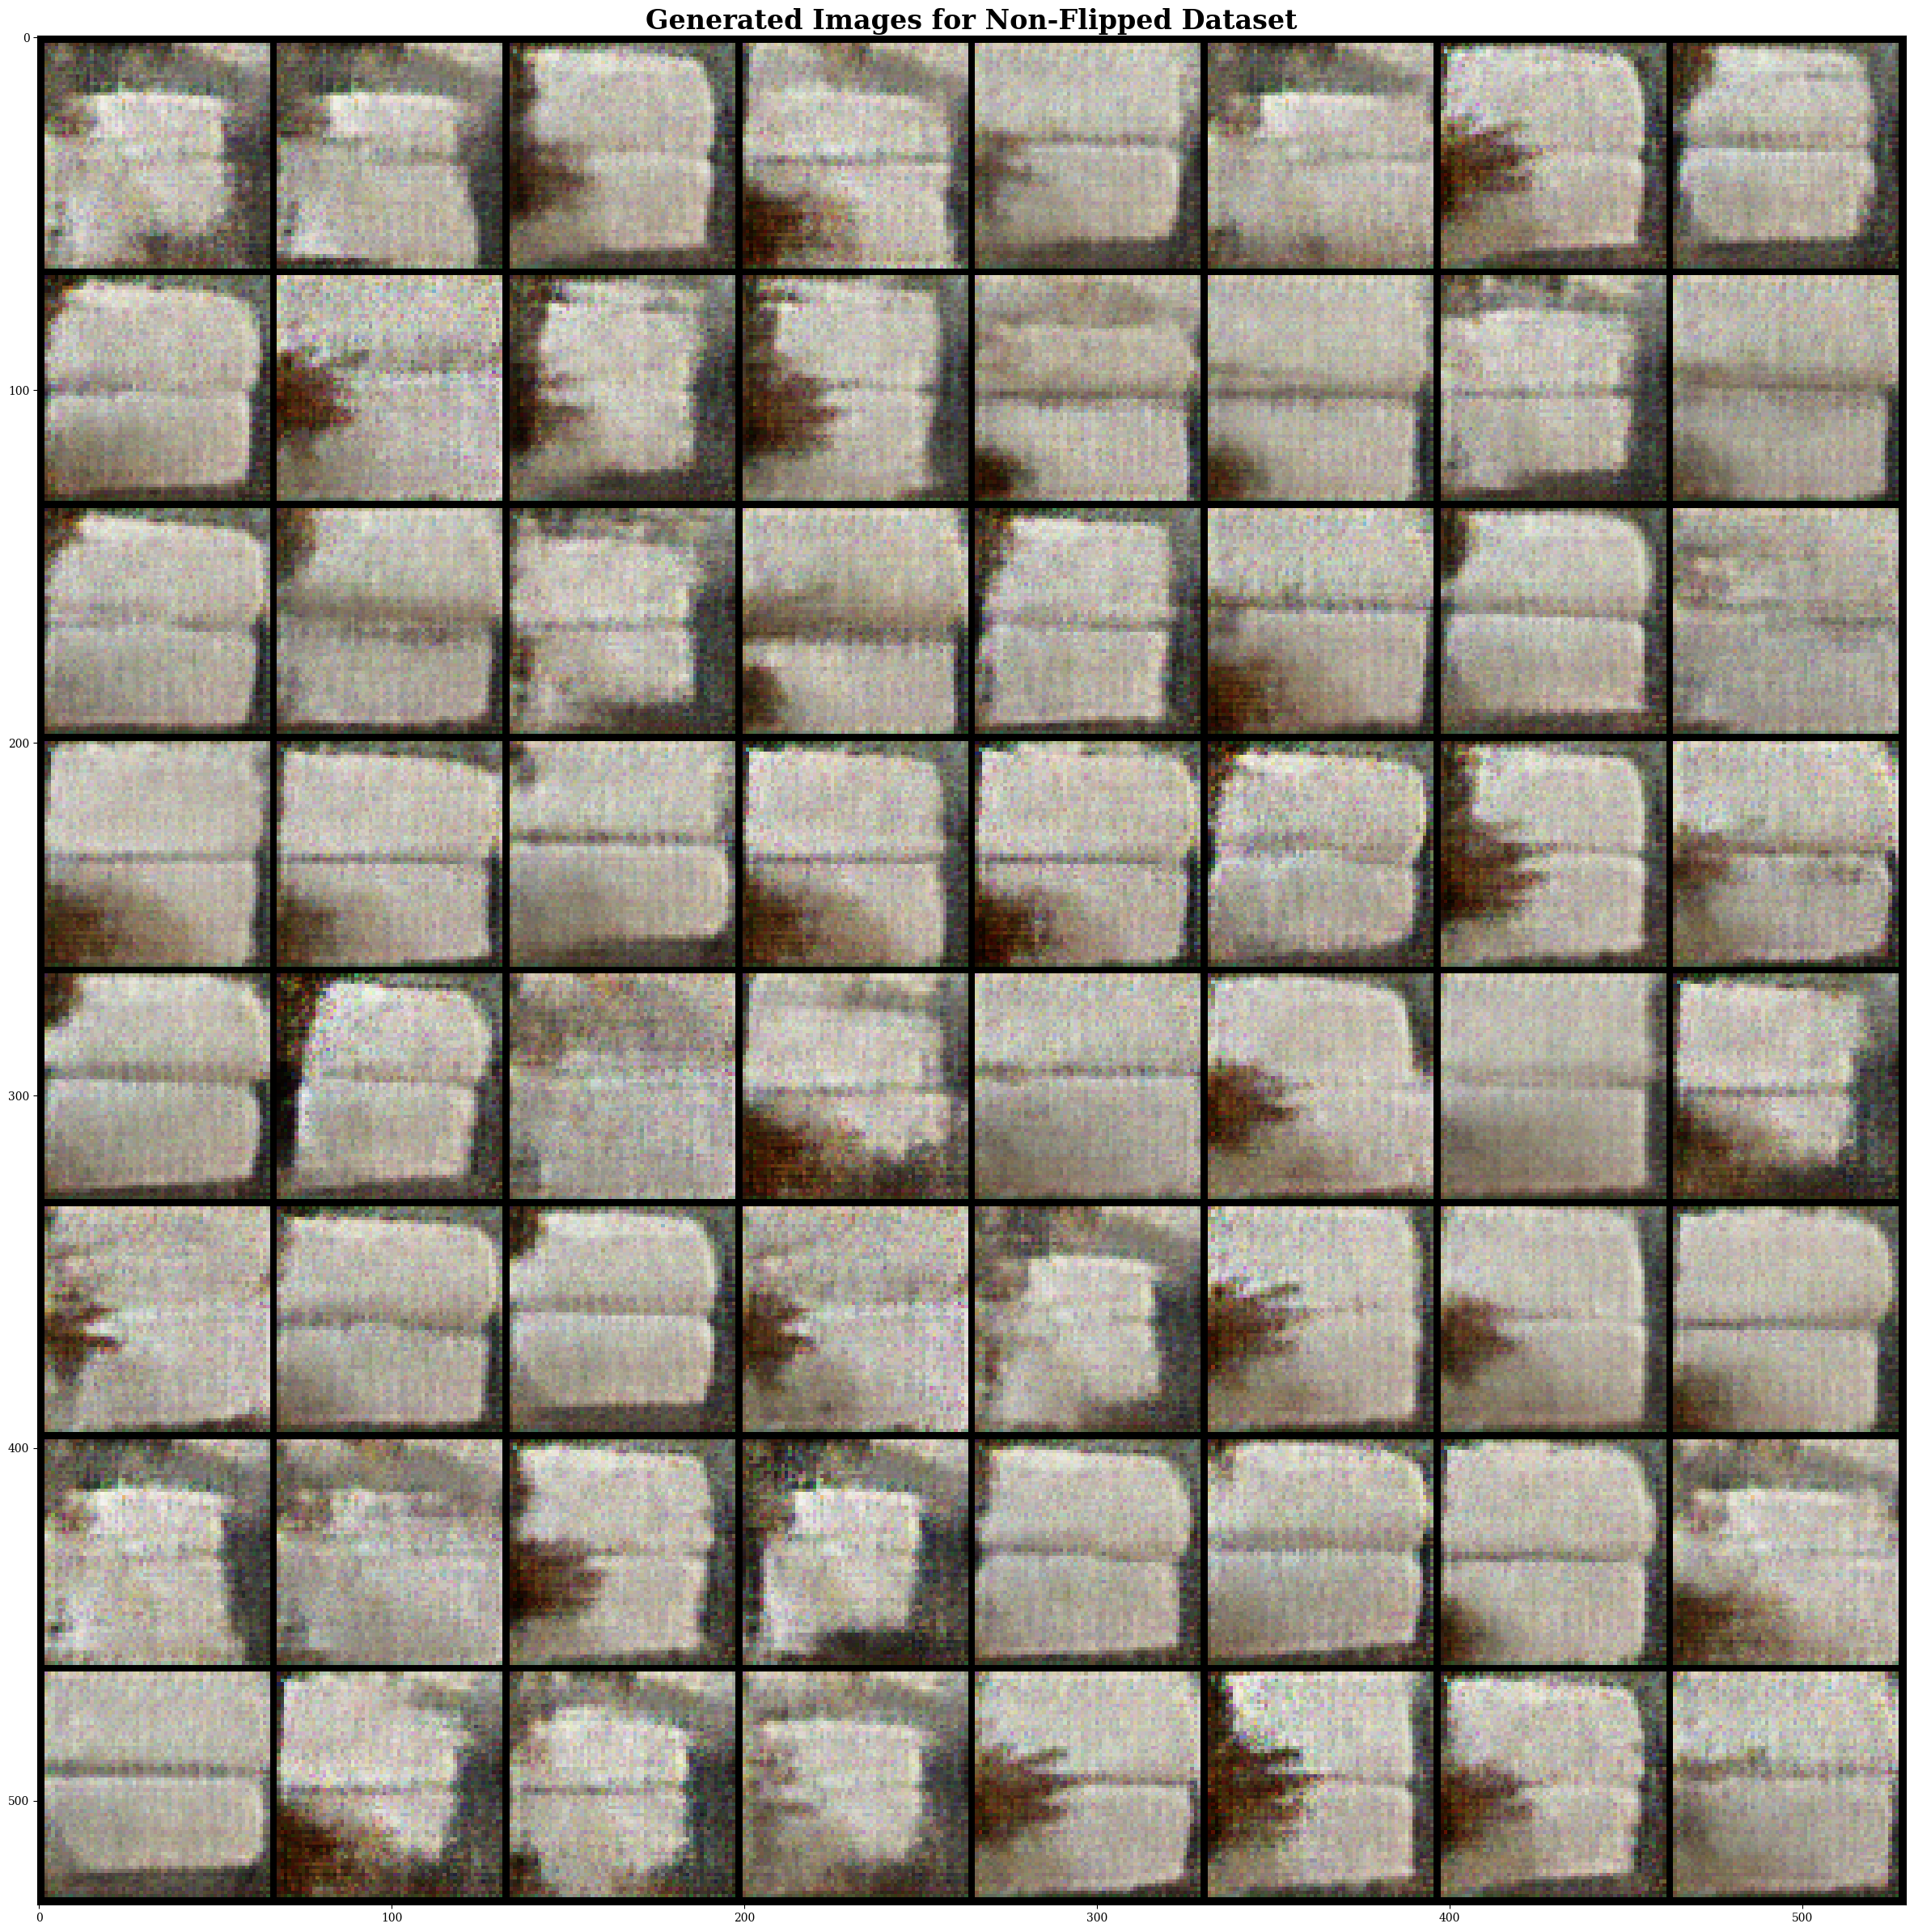

In [190]:
from torchvision.utils import make_grid
# Generate new examples
gen_imgs_noflip = generator(torch.randn(1500, latent_dim, 1, 1, device=device)).detach().cpu()

plt.figure(figsize=(150, 30))
plt.imshow(make_grid(gen_imgs_noflip[:64], nrow=8, normalize=True, value_range=(-1, 1)).permute(1, 2, 0))
plt.title("Generated Images for Non-Flipped Dataset", fontsize=24, fontweight='bold')
plt.show()

In [205]:
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()

# Normalize and clip gen_imgs and gen_imgs_noflip to [0, 1]
gen_imgs_norm = (gen_imgs * 0.5 + 0.5).clamp(0, 1)
gen_imgs_noflip_norm = (gen_imgs_noflip * 0.5 + 0.5).clamp(0, 1)

# Permute from (N, C, H, W) to (N, H, W, C) for PIL conversion
gen_imgs_norm_permuted = gen_imgs_norm.permute(0, 2, 3, 1)
gen_imgs_noflip_norm_permuted = gen_imgs_noflip_norm.permute(0, 2, 3, 1)

# Convert tensors to PIL images and create labeled datasets
gen_imgs_dataset = [(to_pil(img.permute(2, 0, 1)), 1) for img in gen_imgs_norm_permuted]
gen_imgs_noflip_dataset = [(to_pil(img.permute(2, 0, 1)), 0) for img in gen_imgs_noflip_norm_permuted]

In [206]:
generated_combined_dataset = gen_imgs_dataset + gen_imgs_noflip_dataset

generated_dataset = []
for img, label in generated_combined_dataset:
    img = img.resize((224, 224))
    generated_dataset.append((img, label))

with open('generated_dataset.pkl', 'wb') as f:
    pickle.dump(generated_dataset, f)